In [2]:
# Step 1: Kaggle API setup
!pip install -q kaggle

import os
os.environ['KAGGLE_USERNAME'] = "your_kaggle_username"
os.environ['KAGGLE_KEY'] = "your_kaggle_api_key"

# Step 2: Download dataset
!kaggle datasets download -d camnugent/california-housing-prices -p ./ --unzip

# Step 3: Split into train/test
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("housing.csv")
df.rename(columns={"median_house_value": "target"}, inplace=True)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)

print("✅ train.csv & test.csv created")
print("Train:", train_df.shape, "| Test:", test_df.shape)
print("Columns:", df.columns.tolist())

Dataset URL: https://www.kaggle.com/datasets/camnugent/california-housing-prices
License(s): CC0-1.0
  0% 0.00/400k [00:00<?, ?B/s]
100% 400k/400k [00:00<00:00, 746MB/s]
✅ train.csv & test.csv created
Train: (16512, 10) | Test: (4128, 10)
Columns: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'target', 'ocean_proximity']


In [3]:
# Linear Regression from scratch (Normal Equation + Batch Gradient Descent)
# Minimal comments — section headings used as requested.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

plt.rcParams['figure.dpi'] = 150
os.makedirs('figures', exist_ok=True)
os.makedirs('models', exist_ok=True)

# A) Utility: load CSV & detect target
def try_load_csv(paths):
    for p in paths:
        if os.path.exists(p):
            try:
                return pd.read_csv(p)
            except Exception as e:
                print(f"Found file at {p} but failed to read: {e}")
    raise FileNotFoundError(f"None of the provided paths exist: {paths}")

train_paths = ["train.csv", "./train.csv", "/mnt/data/train.csv"]
test_paths = ["test.csv", "./test.csv", "/mnt/data/test.csv"]

train_df = try_load_csv(train_paths)
test_df = try_load_csv(test_paths)

possible_targets = ['target', 'median_house_value', 'MedHouseVal', 'median_house_value_per_unit', 'y']
def detect_target(df):
    for col in df.columns:
        if col.lower() in [t.lower() for t in possible_targets]:
            return col
    if np.issubdtype(df.iloc[:, -1].dtype, np.number):
        return df.columns[-1]
    raise ValueError("Could not detect target column. Rename target to one of: " + ",".join(possible_targets))

target_col = detect_target(train_df)
print("Detected target:", target_col)

Detected target: target


In [4]:
# B) Prepare X, y and numeric columns alignment
X_train_raw = train_df.drop(columns=[target_col])
y_train = train_df[target_col].values
X_test_raw = test_df.drop(columns=[target_col])
y_test = test_df[target_col].values

numeric_cols_train = X_train_raw.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_test = X_test_raw.select_dtypes(include=[np.number]).columns.tolist()
common_numeric = [c for c in numeric_cols_train if c in numeric_cols_test]

X_train_num = X_train_raw[common_numeric].copy()
X_test_num = X_test_raw[common_numeric].copy()

In [5]:
# C) Handle NaNs (mask-based, safe)
mask_train = ~X_train_num.isnull().any(axis=1).values
X_train_num = X_train_num[mask_train].reset_index(drop=True)
y_train = y_train[mask_train]

mask_test = ~X_test_num.isnull().any(axis=1).values
X_test_num = X_test_num[mask_test].reset_index(drop=True)
y_test = y_test[mask_test]

print("Shapes after NaN handling:", X_train_num.shape, X_test_num.shape)

Shapes after NaN handling: (16512, 8) (3921, 8)


In [6]:
# D) Standardize features and add bias
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num.values)
X_test_scaled = scaler.transform(X_test_num.values)

def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

X_train = add_bias(X_train_scaled)
X_test = add_bias(X_test_scaled)

X_train_unscaled = add_bias(X_train_num.values)
X_test_unscaled = add_bias(X_test_num.values)

In [7]:
# E) Normal equation (robust with optional L2)
def normal_equation(X, y, l2=0.0):
    d = X.shape[1]
    reg = np.eye(d) * l2
    reg[0, 0] = 0.0
    A = X.T.dot(X) + reg
    b = X.T.dot(y)
    try:
        theta = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        theta = np.linalg.pinv(A).dot(b)
    return theta

theta_normal = normal_equation(X_train, y_train)
print("Normal eq theta shape:", theta_normal.shape)


Normal eq theta shape: (9,)


In [8]:
# F) Loss, gradient, batch GD (support l2 and early stop)
def mse_loss(X, y, theta):
    n = X.shape[0]
    preds = X.dot(theta)
    return 0.5 * np.mean((preds - y) ** 2)  # 0.5 * MSE

def grad_mse(X, y, theta, l2=0.0):
    n = X.shape[0]
    g = (1.0 / n) * X.T.dot(X.dot(theta) - y)
    if l2 > 0:
        reg = (l2 / n) * theta
        reg[0] = 0.0
        g += reg
    return g

def batch_gradient_descent(X, y, alpha=0.01, n_iter=1000, tol=None, verbose=False, l2=0.0):
    n, d = X.shape
    theta = np.zeros(d)
    losses = []
    for itr in range(n_iter):
        g = grad_mse(X, y, theta, l2=l2)
        theta = theta - alpha * g
        loss = mse_loss(X, y, theta)
        losses.append(loss)
        if tol is not None and itr > 0 and abs(losses[-2] - loss) < tol:
            break
        if verbose and (itr % (max(1, n_iter//10)) == 0):
            print(f"Iter {itr} loss {loss:.6e}")
    return theta, np.array(losses)

In [9]:
# G) Run GD for several learning rates
learning_rates = [1e-3, 1e-4, 1e-5]
results = {}
for lr in learning_rates:
    theta_gd, losses = batch_gradient_descent(X_train, y_train, alpha=lr, n_iter=10000, tol=1e-12)
    y_pred_gd = X_test.dot(theta_gd)
    results[lr] = {'theta': theta_gd, 'losses': losses, 'y_pred': y_pred_gd}
    print(f"LR {lr} final train loss {losses[-1]:.6e}")

# unscaled demonstration (single lr)
theta_gd_unscaled, losses_unscaled = batch_gradient_descent(X_train_unscaled, y_train, alpha=1e-7, n_iter=10000, tol=1e-12)
y_pred_gd_unscaled = X_test_unscaled.dot(theta_gd_unscaled)

LR 0.001 final train loss 2.555277e+09
LR 0.0001 final train loss 6.461921e+09
LR 1e-05 final train loss 2.361202e+10


In [10]:
# H) sklearn LinearRegression (bias column present -> fit_intercept=False)
sk_model = LinearRegression(fit_intercept=False)
sk_model.fit(X_train, y_train)
sk_theta = sk_model.coef_.ravel()
y_pred_sk = sk_model.predict(X_test)

In [12]:
# I) Predictions & metrics
def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAE': mae}

y_pred_ne = X_test.dot(theta_normal)
metrics_ne = metrics(y_test, y_pred_ne)

for lr in learning_rates:
    results[lr]['metrics'] = metrics(y_test, results[lr]['y_pred'])

metrics_unscaled = metrics(y_test, y_pred_gd_unscaled)
metrics_sk = metrics(y_test, y_pred_sk)

# choose best lr by test MSE
best_lr = min(learning_rates, key=lambda lr: results[lr]['metrics']['MSE'])
print("Best lr by test MSE:", best_lr)

Best lr by test MSE: 0.001


In [ ]:
# J) Print parameter comparison
print("\nFirst 6 coeffs (bias + first 5 features):")
for label, theta in [('NormalEq', theta_normal), ('GD', results[best_lr]['theta']), ('Sklearn', sk_theta)]:
    print(label, np.round(theta[:6], 6))

def rel_diff(a, b):
    return np.linalg.norm(a - b) / (np.linalg.norm(a) + 1e-12)

print("Relative diff NE vs SK:", rel_diff(theta_normal, sk_theta))
print("Relative diff NE vs GD:", rel_diff(theta_normal, results[best_lr]['theta']))

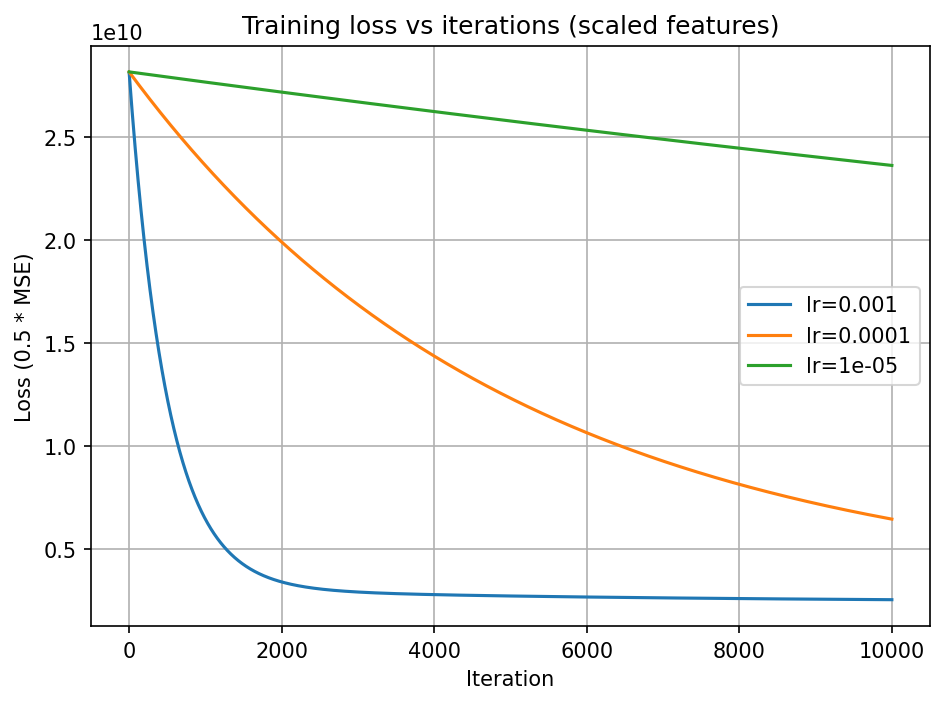

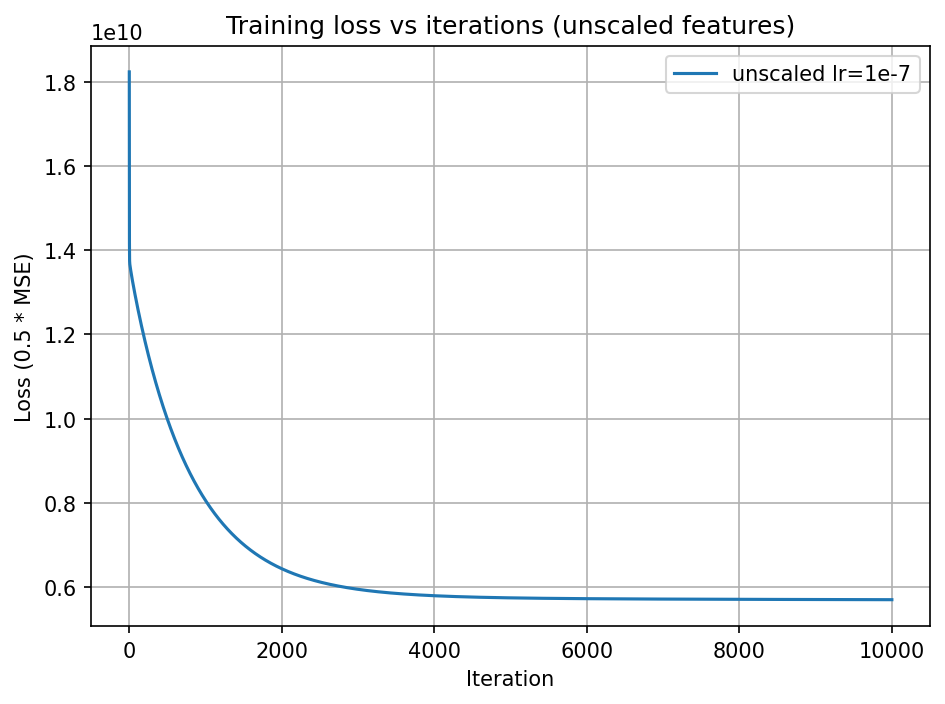

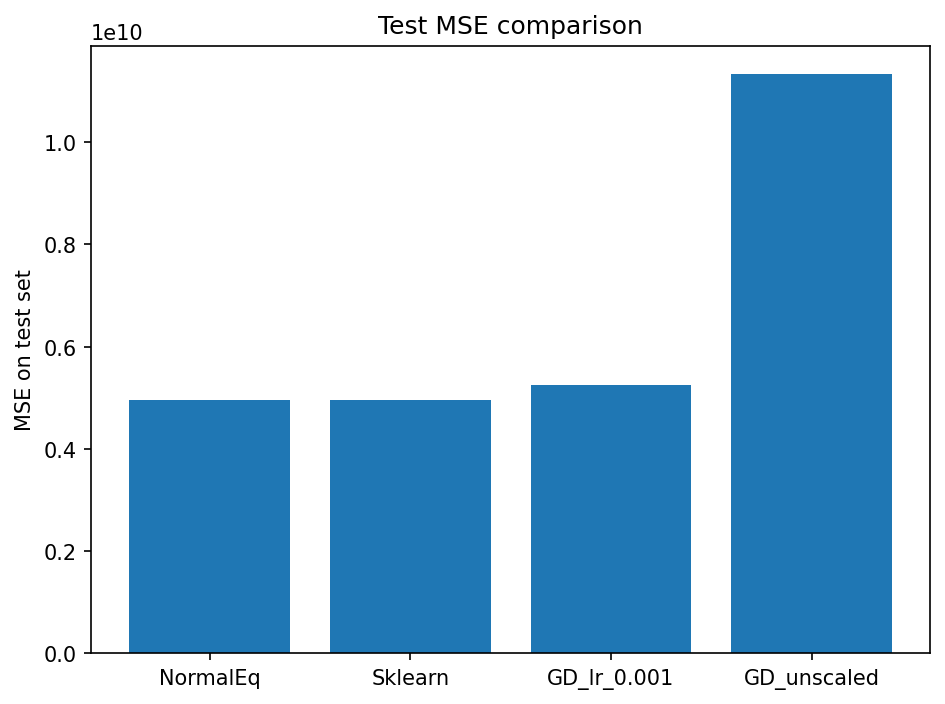

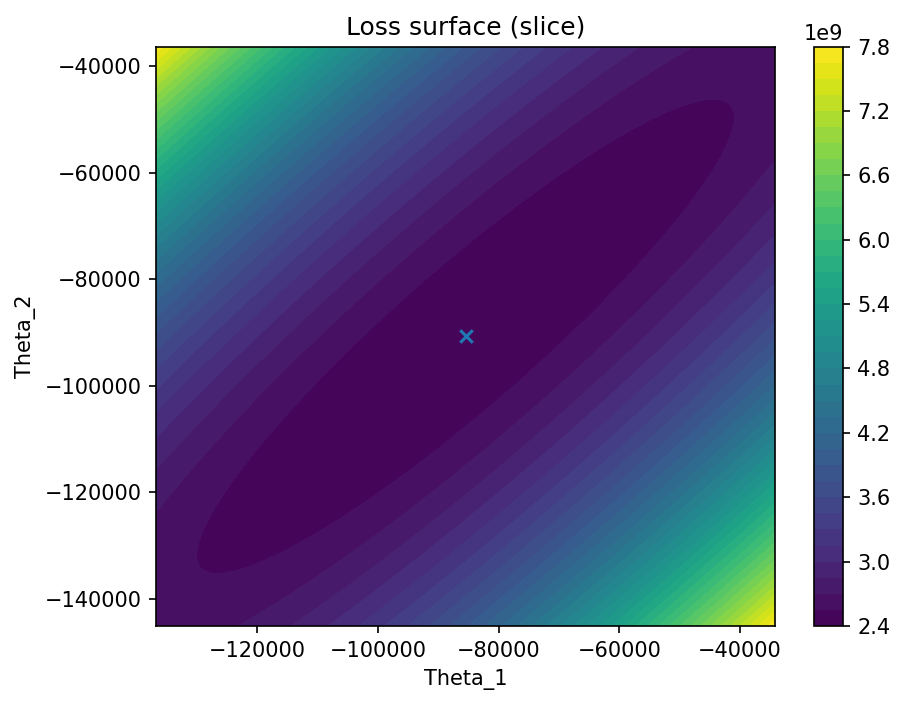

In [14]:
# K) Visualizations (save PNG + PDF)
# Loss vs iterations (scaled)
plt.figure()
for lr in learning_rates:
    loss = results[lr]['losses']
    plt.plot(np.arange(len(loss)), loss, label=f"lr={lr}")
plt.xlabel('Iteration')
plt.ylabel('Loss (0.5 * MSE)')
plt.title('Training loss vs iterations (scaled features)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/loss_vs_iterations_scaled.png')
plt.savefig('figures/loss_vs_iterations_scaled.pdf')

# Loss vs iterations (unscaled)
plt.figure()
plt.plot(np.arange(len(losses_unscaled)), losses_unscaled, label='unscaled lr=1e-7')
plt.xlabel('Iteration')
plt.ylabel('Loss (0.5 * MSE)')
plt.title('Training loss vs iterations (unscaled features)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/loss_vs_iterations_unscaled.png')
plt.savefig('figures/loss_vs_iterations_unscaled.pdf')

# Test MSE comparison bar
val_metrics = {
    'NormalEq': metrics_ne,
    'Sklearn': metrics_sk,
    f'GD_lr_{best_lr}': results[best_lr]['metrics'],
    'GD_unscaled': metrics_unscaled
}
plt.figure()
labels = list(val_metrics.keys())
mses = [val_metrics[k]['MSE'] for k in labels]
plt.bar(labels, mses)
plt.ylabel('MSE on test set')
plt.title('Test MSE comparison')
plt.tight_layout()
plt.savefig('figures/test_mse_comparison.png')
plt.savefig('figures/test_mse_comparison.pdf')

# Loss surface (slice over two params) if possible
if X_train.shape[1] >= 3:
    i1, i2 = 1, 2
    base_theta = theta_normal.copy()
    grid_size = 80
    def coef_span(val):
        return max(1.0, abs(val) * 0.6)
    t1_span = coef_span(base_theta[i1])
    t2_span = coef_span(base_theta[i2])
    t1_vals = np.linspace(base_theta[i1] - t1_span, base_theta[i1] + t1_span, grid_size)
    t2_vals = np.linspace(base_theta[i2] - t2_span, base_theta[i2] + t2_span, grid_size)
    T1, T2 = np.meshgrid(t1_vals, t2_vals)
    losses_grid = np.zeros_like(T1)
    for a in range(grid_size):
        for b in range(grid_size):
            th = base_theta.copy()
            th[i1] = T1[a, b]
            th[i2] = T2[a, b]
            losses_grid[a, b] = mse_loss(X_train, y_train, th)
    plt.figure()
    cp = plt.contourf(T1, T2, losses_grid, levels=40)
    plt.colorbar(cp)
    plt.scatter([base_theta[i1]], [base_theta[i2]], marker='x')
    plt.xlabel(f'Theta_{i1}')
    plt.ylabel(f'Theta_{i2}')
    plt.title('Loss surface (slice)')
    plt.tight_layout()
    plt.savefig('figures/loss_surface_two_params.png')
    plt.savefig('figures/loss_surface_two_params.pdf')


In [15]:
# L) Save models, report
np.savez('models/thetas.npz', theta_normal=theta_normal, theta_gd=results[best_lr]['theta'], theta_sklearn=sk_theta)

report_df = pd.DataFrame.from_dict({k: v if isinstance(v, dict) else v for k, v in val_metrics.items()}, orient='index')
report_df.to_csv('figures/metrics_summary.csv')

# M) Final prints
print("\nFinal metrics summary on test set:")
print("Normal Equation:", metrics_ne)
print(f"Best GD (lr={best_lr}):", results[best_lr]['metrics'])
print("Sklearn LinearRegression:", metrics_sk)
print("\nSaved plots to ./figures/ and models to ./models/. Done.")


Final metrics summary on test set:
Normal Equation: {'MSE': 4953936521.375315, 'RMSE': np.float64(70384.20647684617), 'R2': 0.623019476732215, 'MAE': 51338.18712025207}
Best GD (lr=0.001): {'MSE': 5247257211.274887, 'RMSE': np.float64(72437.95421790214), 'R2': 0.60069860388968, 'MAE': 52934.2633271938}
Sklearn LinearRegression: {'MSE': 4953936521.375315, 'RMSE': np.float64(70384.20647684617), 'R2': 0.623019476732215, 'MAE': 51338.18712025202}

Saved plots to ./figures/ and models to ./models/. Done.
